In [306]:
train = pd.read_csv("../dataset/train.csv")
original_data = train.copy()
test = pd.read_csv("../dataset/test.csv")
original_test = test.copy()

In [307]:
train = train.drop("Upc", axis=1)
train = train[train["DepartmentDescription"] != 'HEALTH AND BEAUTY AIDS']

In [308]:
wd = {
    "Monday": 0,
    "Tuesday": 1,
    "Wednesday": 2,
    "Thursday": 3, 
    "Friday": 4,
    "Saturday": 5,
    "Sunday": 6,
}

In [309]:
def add_return(data):
    """
    Add new feature "return" if ScanCount < 0.
    1: return occured, 0: no return.
    """
    data.loc[data.ScanCount < 0, "Return"] = 1
    data.loc[data.Return != 1, "Return"] = 0

In [310]:
# 주석 처리한 부분을 실행하면 0, 1로 변경되어서 실행 안하도록 코드 수정했습니다.

def count_per_desc(data):
    """
    OneHotEncoding DepartmentDescription 
    then multiply ScanCount.
    """
    dummies = pd.get_dummies(data.DepartmentDescription)
#     data[dummies.columns] = dummies
#     data_dummies = data.loc[:, "1-HR PHOTO":"WIRELESS"]
    data_dummies = dummies.apply(lambda x: x * data["ScanCount"])
    data_dummies = data_dummies.replace(-0, 0)
    data[dummies.columns] = data_dummies

In [311]:
train["Weekday"] = train["Weekday"].apply(lambda x: wd[x])
add_return(train)
count_per_desc(train)

In [312]:
train.tail(3)

,TripType,VisitNumber,Weekday,ScanCount,DepartmentDescription,FinelineNumber,Return,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,...,SEAFOOD,SEASONAL,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS
647051,39,191346,6,1,PRODUCE,4170.0,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
647052,8,191347,6,1,DAIRY,1512.0,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
647053,8,191347,6,1,GROCERY DRY GOODS,3600.0,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [313]:
# def mode(x):
#     return max(set(x), key=x.count)

In [314]:
def fineline_dummies(data):
    """
    OneHotEncoding FinelineNumber which appear 
    more than 300 times each Trip Type.
    """
    fineline_ranks = data.FinelineNumber.value_counts()
    fineline_ranks = fineline_ranks[fineline_ranks > 300]
#     columns1 = list(fineline_ranks.index)
    dummies = pd.get_dummies(data.FinelineNumber)
    dummies = dummies[fineline_ranks.index]
    
    data_visit = original_data[["VisitNumber"]]
    dummy_data = pd.concat([dummies, data_visit], axis=1)
    dummy_data = dummy_data.groupby("VisitNumber").aggregate(np.sum) # agg("sum")보다 더 나은 성능
    return dummy_data

In [315]:
# # train_triptype = train[["TripType", "VisitNumber"]] # TripType / Visit
# train_ttwd = train[["TripType", "VisitNumber", "Weekday"]]

# # group_triptype = train_triptype.groupby("VisitNumber").agg(np.max)["TripType"].reset_index()
# group_weekday = train_weekday.groupby("VisitNumber").agg(np.max)["Weekday"].reset_index()

In [316]:
train_max_groupby = train[["TripType", "VisitNumber", "Weekday", "Return"]] # max로 groupby 하는 피처들
group_max = train_max_groupby.groupby("VisitNumber").agg(np.max).reset_index()

In [317]:
dpts = train.DepartmentDescription.unique()

In [318]:
train_dpts = train.loc[:, "1-HR PHOTO":"WIRELESS"]
train_scvn = train[["VisitNumber", "ScanCount"]]
train_sum_groupby = pd.concat([train_scvn, train_dpts], axis=1)

In [319]:
# train_sum_groupby = train.loc[:, "1-HR PHOTO":"WIRELESS"]
# train_scancount = train[["ScanCount"]]
# train_vn_tmp = train[["VisitNumber"]]

In [320]:
# train_sum_grp2 = pd.concat([train_vn_tmp, train_sum_grp, train_scancount], axis=1)
group_sum = train_sum_groupby.groupby("VisitNumber").agg(np.sum).reset_index()

In [321]:
train_vn_left = pd.merge(group_max, group_sum)
train_vn_right = fineline_dummies(train).reset_index()
train_vn = pd.merge(train_vn_left, train_vn_right)

In [287]:
train_vn.shape

,VisitNumber,5501.0,1508.0,135.0,808.0,0.0,9546.0,1407.0,4606.0,115.0,...,1010.0,7199.0,2906.0,6002.0,3171.0,2536.0,6103.0,1121.0,1345.0,3625.0
95669,191343,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
95670,191344,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
95671,191345,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
95672,191346,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
95673,191347,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [323]:
def category_counts(data):
    """
    Count total number of unique DepartmentDescription made on each trip.
    """
    counts = []
    for array in np.asarray(data.loc[:, "1-HR PHOTO":"WIRELESS"]):
        count = 0
        for item in array:
            if item > 0:
                count += 1
        counts.append(count)
    cat_counts = pd.DataFrame(counts)
    cat_counts = cat_counts.rename(columns={0:"CategoryCount"})
    cat_counts = cat_counts.set_index(data.index)
    data.insert(4, "CategoryCounts", cat_counts)

In [324]:
category_counts(train_vn)

In [325]:
train_vn.tail(3)

,VisitNumber,TripType,Weekday,Return,CategoryCounts,ScanCount,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,...,1010.0,7199.0,2906.0,6002.0,3171.0,2536.0,6103.0,1121.0,1345.0,3625.0
95671,191345,39,6,0.0,8,17,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
95672,191346,39,6,0.0,8,17,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
95673,191347,8,6,0.0,2,2,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [326]:
wd_dummis = pd.get_dummies(train_vn[["Weekday"]].astype("str"))

In [327]:
train_vn_wd_ohe = pd.concat([train_vn, wd_dummis], axis=1)

In [328]:
train_vn_wd_ohe = train_vn_wd_ohe.drop("Weekday", axis=1)

In [329]:
# y = train_vn["TripType"].values
# X = train_vn.drop("TripType", axis=1).values

In [330]:
y = train_vn_wd_ohe["TripType"].values
X = train_vn_wd_ohe.drop("TripType", axis=1).values

In [331]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [332]:
from sklearn.ensemble import RandomForestClassifier
rbf = RandomForestClassifier(n_estimators=100, max_features=0.6, 
                             min_samples_split=50, n_jobs=-1, random_state=0)
rbf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=0.8, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=30,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [333]:
print("Train score: {:.3f}".format(rbf.score(X_train, y_train)))
print("Test score: {:.3f}".format(rbf.score(X_test, y_test)))

Train score: 0.858
Test score: 0.700


In [452]:
pred2 = rbf.predict(X_test)

In [457]:
len(set(pred2))

37

In [185]:
# from sklearn.ensemble import GradientBoostingClassifier

# gbrt = GradientBoostingClassifier(random_state=0)
# gbrt.fit(X_train, y_train)

# print("Train score: {:.3f}".format(gbrt.score(X_train, y_train)))
# print("Test score: {:.3f}".format(gbrt.score(X_test, y_test)))

KeyboardInterrupt: 

In [512]:
importance = rbf.feature_importances_

In [531]:
pairs = []
for idx, value in enumerate(importance):
    pairs.append((abs(value), train_vn_wd_ohe.columns[idx]))
pairs.sort(key=lambda x: x[0], reverse=True)
for pair in pairs[:20]:
    print("importance: {:4f} feature: {}".format(pair[0], pair[1]))

importance: 0.207475 feature: VisitNumber
importance: 0.069255 feature: TripType
importance: 0.048111 feature: Return
importance: 0.030503 feature: CategoryCounts
importance: 0.027496 feature: 1-HR PHOTO
importance: 0.026274 feature: ACCESSORIES
importance: 0.024653 feature: AUTOMOTIVE
importance: 0.023456 feature: BAKERY
importance: 0.023276 feature: BATH AND SHOWER
importance: 0.022354 feature: BEAUTY
importance: 0.019384 feature: BEDDING
importance: 0.018194 feature: BOOKS AND MAGAZINES
importance: 0.018067 feature: BOYS WEAR
importance: 0.015182 feature: BRAS & SHAPEWEAR
importance: 0.015137 feature: CAMERAS AND SUPPLIES
importance: 0.015128 feature: CANDY, TOBACCO, COOKIES
importance: 0.013496 feature: CELEBRATION
importance: 0.012088 feature: COMM BREAD
importance: 0.011235 feature: CONCEPT STORES
importance: 0.011215 feature: COOK AND DINE


In [520]:
importance.sort()

In [522]:
importance = importance[::-1]

In [527]:
labels = [label[1] for label in pairs]

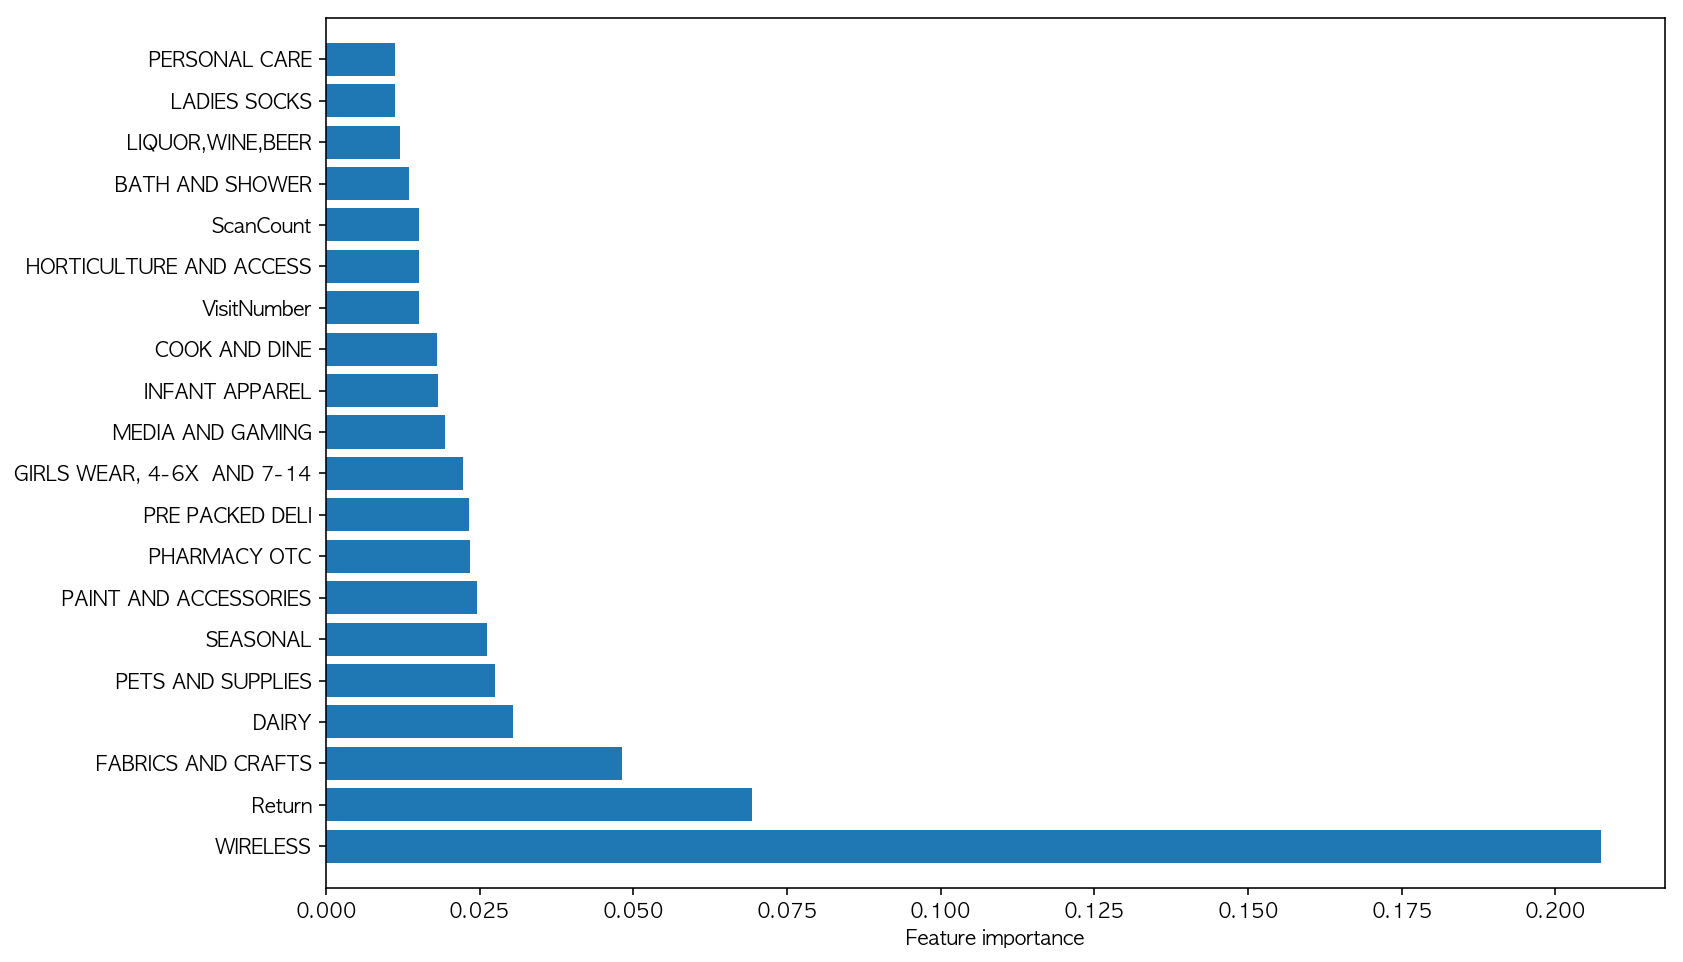

In [530]:
plt.figure(figsize=(12, 8))
plt.barh(range(20), importance[:20], align="center")
plt.yticks(np.arange(20), labels[:20])
plt.xlabel("Feature importance")
plt.ylim(-1, 20)
plt.show()

In [499]:
# def plot_feature_importance(model):
#     n_features = X.shape[1]
#     plt.barh(range(n_features), model.feature_importances_, align='center')
#     plt.yticks(np.arange(n_features), train_vn_wd_ohe.columns) 
#     plt.xlabel("Feature importance")
#     plt.ylim(-1, n_features)

In [334]:
test = test.drop("Upc", axis=1)

In [335]:
test["Weekday"] = test["Weekday"].apply(lambda x: wd[x])
add_return(test)
count_per_desc(test)

In [336]:
test.tail(3)

,VisitNumber,Weekday,ScanCount,DepartmentDescription,FinelineNumber,Return,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,...,SEAFOOD,SEASONAL,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS
653643,191348,6,1,MENS WEAR,8220.0,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
653644,191348,6,1,SWIMWEAR/OUTERWEAR,114.0,0.0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
653645,191348,6,1,MENS WEAR,4923.0,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [337]:
def fineline_dummies_test(data):
    """
    OneHotEncoding FinelineNumber which appear 
    more than 500 times each Trip Type.
    """
#     train_fineline = original_data["FinelineNumber"].unique()
#     test_fineline = original_test["FinelineNumber"].unique()
#     intersection_fineline = list(set(train_fineline).intersection(set(test_fineline)))
    
    fineline_ranks = original_data.FinelineNumber.value_counts()
    fineline_ranks = fineline_ranks[fineline_ranks > 300]
#     columns1 = list(fineline_ranks.index)
    dummies = pd.get_dummies(data.FinelineNumber)
    dummies = dummies[fineline_ranks.index]
    
    data_visit = original_test[["VisitNumber"]]
    dummy_data = pd.concat([dummies, data_visit], axis=1)
    dummy_data = dummy_data.groupby("VisitNumber").aggregate(np.sum) # agg("sum")보다 더 나은 성능
    return dummy_data

In [338]:
test_weekday = test[["VisitNumber", "Weekday"]]
group_weekday_test = test_weekday.groupby("VisitNumber").agg(np.max)["Weekday"].reset_index()

In [339]:
test_max_grp = test[["VisitNumber", "Weekday", "Return"]]
group_max_test = test_max_grp.groupby("VisitNumber").agg(np.max).reset_index()

In [340]:
test_sum_grp = test.loc[:, "1-HR PHOTO":"WIRELESS"]
test_scancount = test[["ScanCount"]]
test_vn_tmp = test[["VisitNumber"]]

In [341]:
test_sum_groupby = pd.concat([test_vn_tmp, test_sum_grp, test_scancount], axis=1)
group_sum_test = test_sum_groupby.groupby("VisitNumber").agg(np.sum).reset_index()

In [342]:
test_vn_left = pd.merge(group_max_test, group_sum_test)
test_vn_right = fineline_dummies_test(test).reset_index()
test_vn = pd.merge(test_vn_left, test_vn_right)

In [343]:
category_counts(test_vn)

In [346]:
wd_dummis = pd.get_dummies(test_vn[["Weekday"]].astype("str"))
test_vn_wd_ohe = pd.concat([test_vn, wd_dummis], axis=1)
test_vn_wd_ohe = test_vn_wd_ohe.drop("Weekday", axis=1)

In [347]:
train_vn_wd_ohe.shape, test_vn_wd_ohe.shape

((95674, 606), (95674, 605))

In [ ]:
df = pd.DataFrame(prob, columns=classes)
VisitNumberDF = pd.DataFrame(testDF.iloc[0::,0:1].values, columns=['VisitNumber'])
ProbabilitiesDF = pd.DataFrame(prob, columns=classes)
ProbabilitiesDF.columns = ProbabilitiesDF.columns.map(lambda x: str('TripType_') + str(x))
SubmissionDF = VisitNumberDF.join(ProbabilitiesDF)

In [487]:
pred = rbf.predict(test_vn_wd_ohe)

In [475]:
rbf.classes_.shape

(38,)

In [489]:
pred = pd.get_dummies(pred)

In [495]:
a = sorted(original_data["TripType"].unique())

In [492]:
pred.columns

Int64Index([  3,   4,   5,   6,   7,   8,   9,  12,  15,  18,  19,  20,  21,
             22,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,
             36,  37,  38,  39,  40,  41,  42, 999],
           dtype='int64')

In [496]:
set(a) - set(pred.columns)

{14, 23, 43, 44}

In [498]:
pred.columns = pred.columns.map(lambda x: str("TripType_") + str(x))

In [500]:
pred_concat = pd.concat([test_vn_wd_ohe[["VisitNumber"]], pred], axis=1)

In [501]:
pred_concat.to_csv("submission_0406.csv", index=False)

In [517]:
pred_concat = pred_concat.astype('int64')

In [505]:
sample.head()

,VisitNumber,TripType_3,TripType_4,TripType_5,TripType_6,TripType_7,TripType_8,TripType_9,TripType_12,TripType_14,...,TripType_36,TripType_37,TripType_38,TripType_39,TripType_40,TripType_41,TripType_42,TripType_43,TripType_44,TripType_999
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [526]:
sample.columns

Index(['VisitNumber', 'TripType_3', 'TripType_4', 'TripType_5', 'TripType_6',
       'TripType_7', 'TripType_8', 'TripType_9', 'TripType_12', 'TripType_14',
       'TripType_15', 'TripType_18', 'TripType_19', 'TripType_20',
       'TripType_21', 'TripType_22', 'TripType_23', 'TripType_24',
       'TripType_25', 'TripType_26', 'TripType_27', 'TripType_28',
       'TripType_29', 'TripType_30', 'TripType_31', 'TripType_32',
       'TripType_33', 'TripType_34', 'TripType_35', 'TripType_36',
       'TripType_37', 'TripType_38', 'TripType_39', 'TripType_40',
       'TripType_41', 'TripType_42', 'TripType_43', 'TripType_44',
       'TripType_999'],
      dtype='object')

In [527]:
pred_concat.columns

Index(['VisitNumber', 'TripType_3', 'TripType_4', 'TripType_5', 'TripType_6',
       'TripType_7', 'TripType_8', 'TripType_9', 'TripType_12', 'TripType_15',
       'TripType_18', 'TripType_19', 'TripType_20', 'TripType_21',
       'TripType_22', 'TripType_24', 'TripType_25', 'TripType_26',
       'TripType_27', 'TripType_28', 'TripType_29', 'TripType_30',
       'TripType_31', 'TripType_32', 'TripType_33', 'TripType_34',
       'TripType_35', 'TripType_36', 'TripType_37', 'TripType_38',
       'TripType_39', 'TripType_40', 'TripType_41', 'TripType_42',
       'TripType_999'],
      dtype='object')

In [480]:
a = pd.get_dummies(pred.astype(str))

In [483]:
a.columns = a.columns.astype(int)

In [486]:
aa.reindex_axis(sorted(a.columns), axis=1)

,3,4,5,6,7,8,9,12,15,18,...,34,35,36,37,38,39,40,41,42,999
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [416]:
pred.shape

(95674,)

In [373]:
tt = original_data["TripType"].unique()

In [374]:
tt.sort()

In [375]:
tt_cols = ["TripType_" + str(tt) for tt in tt]

In [437]:
pred = pd.DataFrame(pred, columns=["TripType"])
pred = pd.concat([test_vn_wd_ohe["VisitNumber"], pred], axis=1)

In [438]:
pred.tail()

,VisitNumber,TripType
95669,191338,8
95670,191339,31
95671,191340,31
95672,191341,27
95673,191348,31


In [434]:
pd.get_dummies(pred["TripType"]).shape

(95674, 34)

In [386]:
pred = pd.DataFrame(pred, columns=["TripType"])
pred["TripType"] = pred["TripType"].astype(str)
pred_dummies = pd.get_dummies(pred)
pred = pd.concat([test_vn_wd_ohe["VisitNumber"], pred], axis=1)

In [ ]:
original_data.re

In [442]:
tmp = pd.get_dummies(pred[["TripType"]].astype(str))

In [275]:
sample = pd.read_csv("../dataset/sample_submission 2.csv")

In [276]:
sample.tail()

,VisitNumber,TripType_3,TripType_4,TripType_5,TripType_6,TripType_7,TripType_8,TripType_9,TripType_12,TripType_14,...,TripType_36,TripType_37,TripType_38,TripType_39,TripType_40,TripType_41,TripType_42,TripType_43,TripType_44,TripType_999
95669,191338,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
95670,191339,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
95671,191340,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
95672,191341,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
95673,191348,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [466]:
pred = pd.concat([test_vn_wd_ohe[["VisitNumber"]], pred_dummies], axis=1)

In [467]:
pred.shape

(95674, 35)

In [468]:
pred.to_csv("sub.csv", index=False)

In [460]:
pred_dummies.tail()

,TripType_12,TripType_15,TripType_18,TripType_19,TripType_20,TripType_21,TripType_22,TripType_24,TripType_25,TripType_26,...,TripType_4,TripType_40,TripType_41,TripType_42,TripType_5,TripType_6,TripType_7,TripType_8,TripType_9,TripType_999
95669,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
95670,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
95671,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
95672,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
95673,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [77]:
train_fineline = original_data["FinelineNumber"].unique()
test_fineline = original_test["FinelineNumber"].unique()
intersection_fineline = list(set(train_fineline).intersection(set(test_fineline)))

In [111]:
test2 = test[test["FinelineNumber"].isin(intersection_fineline)]

In [146]:
test2 = original_test.copy()

In [147]:
test2["Weekday"] = test2["Weekday"].apply(lambda x: wd[x])
add_return(test2)
count_per_desc(test2)

In [148]:
test_weekday = test2[["VisitNumber", "Weekday"]]
group_weekday_test = test_weekday.groupby("VisitNumber").agg(np.max)["Weekday"].reset_index()

test_max_grp = test2[["VisitNumber", "Weekday", "Return"]]
group_max_test = test_max_grp.groupby("VisitNumber").agg(np.max).reset_index()

In [149]:
test_sum_grp = test2.loc[:, "1-HR PHOTO":"WIRELESS"]
test_scancount = test2[["ScanCount"]]
test_vn_tmp = test2[["VisitNumber"]]

test_sum_groupby = pd.concat([test_vn_tmp, test_sum_grp, test_scancount], axis=1)
group_sum_test = test_sum_groupby.groupby("VisitNumber").agg(np.sum).reset_index()

In [150]:
test_vn_left = pd.merge(group_max_test, group_sum_test)

In [151]:
test_vn_right = fineline_dummies_test(test2).reset_index()

In [154]:
test_vn_left.tail()

,VisitNumber,Weekday,Return,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,BEAUTY,BEDDING,...,SEASONAL,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS,ScanCount
95669,191338,6,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,12
95670,191339,6,0.0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
95671,191340,6,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
95672,191341,6,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,12
95673,191348,6,0.0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,2,0,0,7


In [155]:
test_vn_right.tail()

,index,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber,Return,1-HR PHOTO,ACCESSORIES,...,805.0,3704.0,4500.0,1352.0,3175.0,2352.0,2804.0,1009.0,10.0,7557.0
653641,653641,191348,6,6.657211e+10,1,BATH AND SHOWER,1505.0,0.0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
653642,653642,191348,6,8.818139e+10,1,BATH AND SHOWER,1099.0,0.0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
653643,653643,191348,6,4.282557e+09,1,MENS WEAR,8220.0,0.0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
653644,653644,191348,6,8.046919e+10,1,SWIMWEAR/OUTERWEAR,114.0,0.0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
653645,653645,191348,6,7.871536e+09,1,MENS WEAR,4923.0,0.0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [152]:
test_vn = pd.concat([test_vn_left, test_vn_right], axis=1)
category_counts(test_vn)

KeyError: "Cannot get left slice bound for non-unique label: '1-HR PHOTO'"

In [169]:
train_fineline = original_data["FinelineNumber"].unique()

In [174]:
test_finelines = pd.get_dummies(original_test.FinelineNumber)

In [176]:
test_finelines.shape

(653646, 5203)

In [177]:
train_finelines = pd.get_dummies(original_data.FinelineNumber)

In [178]:
train_finelines.shape

(647054, 5195)

In [ ]:
def fineline_dummies_test(data):
    """
    OneHotEncoding FinelineNumber which appear 
    more than 500 times each Trip Type.
    """
    train_fineline = original_data["FinelineNumber"].unique()
    test_fineline = original_test["FinelineNumber"].unique()
    intersection_fineline = list(set(train_fineline).intersection(set(test_fineline)))
    
    fineline_ranks = original_data.FinelineNumber.value_counts()
    fineline_ranks = fineline_ranks[fineline_ranks > 500]
#     columns1 = list(fineline_ranks.index)
#     dummies = pd.get_dummies(data.FinelineNumber)
    dummies = pd.get_dummies(original_test.FinelineNumber)
    dummies = dummies[fineline_ranks.index]
    
    data_visit = original_test[["VisitNumber"]]
    dummy_data = pd.concat([dummies, data_visit], axis=1)
    dummy_data = dummy_data.groupby("VisitNumber").aggregate(np.sum) # agg("sum")보다 더 나은 성능
    return dummy_data

In [179]:
train_vn = train[["VisitNumber"]]
test_vn = train[["VisitNumber"]]

In [185]:
train_finelines = train_finelines[intersection_fineline]
test_finelines = test_finelines[intersection_fineline]

In [186]:
train_finelines.shape, test_finelines.shape

((647054, 5045), (653646, 5045))

In [190]:
idx = original_data.FinelineNumber.value_counts()[original_data.FinelineNumber.value_counts() > 500]

In [191]:
idx.shape

(273,)

In [193]:
idx = idx.index

In [195]:
train_finelines[idx].shape, test_finelines[idx].shape

((647054, 273), (653646, 273))

In [197]:
original_test.shape

(653646, 6)

In [202]:
pd.concat([original_test[["VisitNumber"]] , test_finelines[idx]], axis=1)["VisitNumber"].unique().shape

(95674,)